In [1]:
# Dirichlet‑Process clustering of NDVI time series
# Piece‑wise (Loredo‑style) temporal model
# PyMC implementation with truncated DP and sequential updating

import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot as plt

import scipy.stats as stats

In [22]:
# ============================================================
# USER PARAMETERS
# ============================================================
MAX_CLUSTERS = 5          # truncation level of DP
N_SEGMENTS   = 23          # piece‑wise bins for temporal model (e.g. 23 for 16‑day NDVI)
ALPHA_DP     = 3.0 #1.0         # DP concentration
SIGMA_MODIS  = 0.02        # NDVI noise (~MODIS typical)

In [23]:
# ============================================================
# UTILITIES
# ============================================================

def doy_to_bin(doy, n_segments=N_SEGMENTS):
    """Map day-of-year to piecewise bin"""
    return np.floor((doy % 365) / 365 * n_segments).astype(int)

In [24]:
def build_model_multi(series_bins, series_values):
    """
    series_bins : list of arrays of bins per series
    series_values: list of NDVI arrays
    """

    n_series = len(series_values)

    with pm.Model() as model:
        # ---------- Stick‑breaking DP ----------
        beta = pm.Beta("beta", 1, ALPHA_DP, shape=MAX_CLUSTERS)
        pi = pm.Deterministic("pi", pm.math.concatenate([beta[0:1], beta[1:] * pt.extra_ops.cumprod(1 - beta[:-1])]))
        pi = pi / pm.math.sum(pi)

        # ---------- Piecewise NDVI per cluster ----------
        a = pm.Uniform("a", lower=0, upper=1.0, shape=(MAX_CLUSTERS, N_SEGMENTS))
        # sigma = pm.HalfNormal("sigma", SIGMA_MODIS)

        # ---------- Cluster assignment per SERIES ----------
        z = pm.Categorical("z", p=pi, shape=n_series)

        # ---------- Likelihood per series ----------
        for i in range(n_series):
            mu_i = a[z[i], series_bins[i]]
            # pm.Normal(f"y_{i}", mu=mu_i, sigma=sigma,
            pm.Normal(f"y_{i}", mu=mu_i, sigma=SIGMA_MODIS,
            observed=series_values[i])

    return model


In [25]:
def build_model_multi_hierar(series_bins, series_values):
    """
    series_bins : list of arrays of bins per series
    series_values: list of NDVI arrays
    """

    n_series = len(series_values)

    with pm.Model() as model:
        # ---------- Stick‑breaking DP ----------
        beta = pm.Beta("beta", 1, ALPHA_DP, shape=MAX_CLUSTERS)
        pi = pm.Deterministic("pi", pm.math.concatenate([beta[0:1], beta[1:] * pt.extra_ops.cumprod(1 - beta[:-1])]))
        pi = pi / pm.math.sum(pi)

        # ---------- Piecewise NDVI per cluster ----------
        # a = pm.Uniform("a", lower=0, upper=1.0, shape=(MAX_CLUSTERS, N_SEGMENTS))
        mu0 = pm.Normal("mu0", 0.3, 0.2, shape=N_SEGMENTS)
        tau = pm.HalfNormal("tau", 0.1)

        a = pm.Normal("a", mu0, tau, shape=(MAX_CLUSTERS,N_SEGMENTS))
        # sigma = pm.HalfNormal("sigma", SIGMA_MODIS)

        # ---------- Cluster assignment per SERIES ----------
        z = pm.Categorical("z", p=pi, shape=n_series)

        # ---------- Likelihood per series ----------
        for i in range(n_series):
            mu_i = a[z[i], series_bins[i]]
            # pm.Normal(f"y_{i}", mu=mu_i, sigma=sigma,
            pm.Normal(f"y_{i}", mu=mu_i, sigma=SIGMA_MODIS,
            observed=series_values[i])

    return model


In [26]:
def synthetic_series(n_series, anios, sigma=SIGMA_MODIS):
    """
    Generate NDVI synthetic series in MODIS 16-day composites (~23 per year)
    Clusters:
        0 → bosque perenne
        1 → cultivo anual
        2 → doble cultivo
    """

    n_quincenas = 23
    q = np.arange(n_quincenas*anios)

    series = []
    true_clusters = []

    for i in range(n_series):
        c = np.random.choice([0,1,2])
        true_clusters.append(c)

        if c == 0:   # bosque
            ndvi = 0.3 + 0.1*np.sin(2*np.pi*q/n_quincenas)

        elif c == 1: # cultivo anual
            ndvi = 0.2 + 0.5*((q%n_quincenas>6)&(q%n_quincenas<15))

        else:        # doble cultivo
            ndvi = 0.2 \
                 + 0.35*((q%n_quincenas>3)&(q%n_quincenas<7)) \
                 + 0.35*((q%n_quincenas>12)&(q%n_quincenas<16))

        ndvi = ndvi.astype(float)
        ndvi += np.random.normal(0, sigma, size=len(q))

        # clip NDVI realista
        ndvi = np.clip(ndvi, 0, 0.9)

        series.append(ndvi)

    return q, np.array(series), np.array(true_clusters)



In [27]:
quincenas, series, true_clusters = synthetic_series(n_series=30, anios=3, sigma=SIGMA_MODIS)

Text(0.5, 1.0, 'Series sintéticas con clusters conocidos')

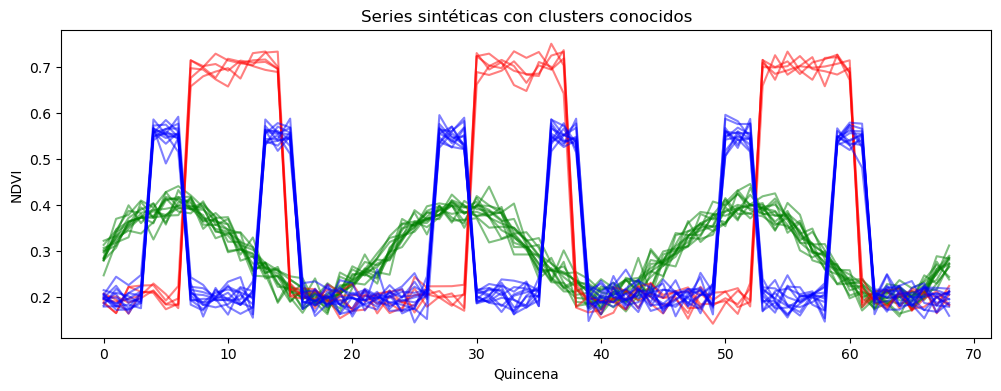

In [28]:
fig = plt.figure(figsize=(12,4))

plt.plot(quincenas, series[true_clusters == 0, :].T, color='green', alpha=0.5)
plt.plot(quincenas, series[true_clusters == 1, :].T, color='red', alpha=0.5)
plt.plot(quincenas, series[true_clusters == 2, :].T, color='blue', alpha=0.5)
plt.xlabel("Quincena")
plt.ylabel("NDVI")
plt.title("Series sintéticas con clusters conocidos")
# plt.plot(true_clusters)

In [ ]:

np.random.seed(0)

# quincenas, series, true_clusters = synthetic_series(n_series=30, anios=3)
# series_bins = [doy_to_bin(quincenas) for _ in series]
# series_bins = [quincenas for _ in series]
series_bins = [np.arange(len(s)) % 23 for s in series]
# model = build_model_multi(series_bins, series)
model = build_model_multi_hierar(series_bins, series)

# with model:
#     trace = pm.sample(draws=5000, tune=1000, chains=4)
#     z_post = trace.posterior["z"].mean(dim=("chain","draw")).values
#     z_est = np.round(z_post).astype(int)

with model:
    trace = pm.sample(draws=2000, tune=500, chains=4, target_accept=0.9)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta, mu0, tau, a]
>CategoricalGibbsMetropolis: [z]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 30 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [30]:
# model.free_RVs

for rv in model.free_RVs:
    print(rv.name, rv.eval().shape)

beta (5,)
mu0 (23,)
tau ()
a (5, 23)
z (30,)


In [31]:
z_samples = trace.posterior["z"].stack(samples=("chain","draw")).values
z_est = stats.mode(z_samples, axis=1, keepdims=False).mode


print("True clusters:")
print(true_clusters)
print("Estimated clusters:")
print(z_est)
print("Estimated N:", len(np.unique(z_est)))

True clusters:
[0 2 1 2 0 2 2 1 1 0 2 0 0 1 2 0 2 0 0 2 0 2 2 0 0 2 0 1 0 2]
Estimated clusters:
[1 0 2 0 1 0 0 2 2 1 0 1 1 2 0 1 0 1 1 0 1 0 0 1 1 0 1 2 1 0]
Estimated N: 3


### Evaluacion convergencia

In [32]:
trace.posterior

<xarray.Dataset> Size: 11MB
Dimensions:     (chain: 4, draw: 2000, mu0_dim_0: 23, a_dim_0: 5, a_dim_1: 23,
                 z_dim_0: 30, beta_dim_0: 5, pi_dim_0: 5)
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 16kB 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * mu0_dim_0   (mu0_dim_0) int64 184B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22
  * a_dim_0     (a_dim_0) int64 40B 0 1 2 3 4
  * a_dim_1     (a_dim_1) int64 184B 0 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21 22
  * z_dim_0     (z_dim_0) int64 240B 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
  * beta_dim_0  (beta_dim_0) int64 40B 0 1 2 3 4
  * pi_dim_0    (pi_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu0         (chain, draw, mu0_dim_0) float64 1MB 0.3857 0.36 ... 0.1921
    a           (chain, draw, a_dim_0, a_dim_1) float64 7MB 0.1993 ... 0.273
    z           (chain, draw, z_dim_0) int64 2MB 1 0 2 0 1 0 0 ... 4 4 2 4 1 4 2
    beta        (chain, draw, beta_dim_0) float64 320kB 0.248 0.5017 ... 0.6615
    tau         (chain, draw) float64 64kB 0.1523 0.1725 0.159 ... 0.1555 0.1521
    pi          (chain, draw, pi_dim_0) float64 320kB 0.248 0.3773 ... 0.3432
Attributes:
    created_at:                 2026-02-20T18:38:12.109295+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.12.0
    sampling_time:              29.762643814086914
    tuning_steps:               500

In [33]:
import arviz as az
# az.summary(trace, var_names=["z"])
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0[0],0.245,0.084,0.088,0.406,0.001,0.001,9812.0,6630.0,1.00
mu0[1],0.250,0.086,0.086,0.408,0.001,0.001,9861.0,6713.0,1.00
mu0[2],0.261,0.086,0.098,0.422,0.001,0.001,10411.0,6781.0,1.00
mu0[3],0.265,0.086,0.089,0.415,0.001,0.001,9579.0,6210.0,1.00
mu0[4],0.368,0.087,0.210,0.537,0.001,0.001,10069.0,6811.0,1.00
...,...,...,...,...,...,...,...,...,...
pi[0],0.247,0.151,0.000,0.449,0.066,0.028,7.0,29.0,1.53
pi[1],0.282,0.121,0.050,0.470,0.046,0.016,8.0,28.0,1.46
pi[2],0.138,0.103,0.000,0.323,0.043,0.021,5.0,28.0,1.94
pi[3],0.045,0.054,0.000,0.156,0.023,0.015,8.0,28.0,1.47


In [34]:
trace.posterior["pi"].mean(dim=("chain","draw")).values

array([0.24681967, 0.28219912, 0.13790593, 0.04539121, 0.07744941])

### Evaluacion clusters

In [35]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def aligned_confusion(true_labels, est_labels):
    true_labels = np.array(true_labels)
    est_labels  = np.array(est_labels)

    cm = confusion_matrix(true_labels, est_labels)

    # Hungarian algorithm → maximizar diagonal
    row_ind, col_ind = linear_sum_assignment(-cm)

    aligned_cm = cm[:, col_ind]
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}

    aligned_est = np.array([mapping[e] for e in est_labels])

    return aligned_cm, aligned_est, mapping


In [36]:
def plot_confusion(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Estimated cluster")
    plt.ylabel("True cluster")
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j],
                     ha="center", va="center",
                     fontsize=12)

    plt.tight_layout()
    plt.show()


Cluster mapping: {1: 0, 2: 1, 0: 2}


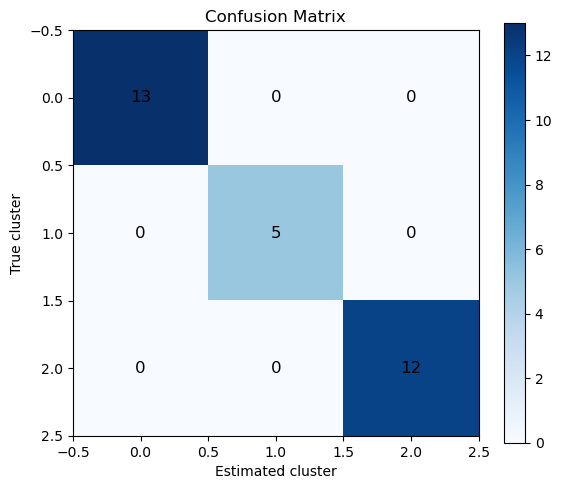

In [37]:
cm, aligned_est, mapping = aligned_confusion(true_clusters, z_est)

print("Cluster mapping:", mapping)
plot_confusion(cm)


Evaluacion series de tiempo

In [38]:
def plot_cluster_ndvi_posterior(trace, quincenas, z_est, ci=0.9):
    """
    trace   : trace de PyMC
    quincenas    : array quincenas
    z_est   : cluster asignado por serie
    """

    a_post = trace.posterior["a"].stack(sample=("chain","draw")).values
    # shape = (Kmax, N_segments, n_samples)

    clusters = np.unique(z_est)
    # bins = np.floor((days % 365) / 365 * n_segments).astype(int)
    bins = quincenas

    plt.figure(figsize=(10,6))

    for k in clusters:

        samples = a_post[k, bins, :]  # (365, n_samples)

        mean = samples.mean(axis=1)
        low  = np.percentile(samples, (1-ci)/2*100, axis=1)
        high = np.percentile(samples, (1+(ci))/2*100, axis=1)

        n_series = np.sum(z_est == k)

        plt.plot(quincenas, mean, label=f"Cluster {k} (n={n_series})")
        plt.fill_between(quincenas, low, high, alpha=0.25)

    plt.xlabel("Quincena")
    plt.ylabel("NDVI")
    plt.title("NDVI promedio por cluster (posterior PyMC)")
    plt.legend()
    plt.grid(True)
    plt.show()


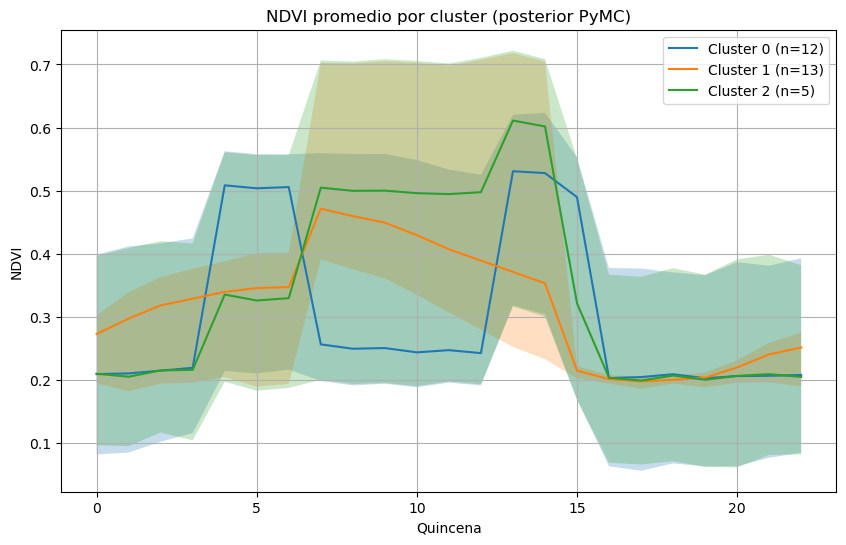

In [39]:
plot_cluster_ndvi_posterior(trace, quincenas[:23], z_est, ci=0.9)

In [40]:
z_est

array([1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 2, 1, 0])